# Задание №1 по курсу "Глубокое обучение"
# Максимальное качество CNN-2
Выполнила: студентка 317 группы Анисимова Д.В.

В задании необходимо было выбрать некоторую архитектуру сверточной нейросети и, рассмотрев указанные ниже параметры, достигнуть наилучшего качества на датасете CIFAR-10. Рассматривались следующие аспекты:
- аугментация
- batch_size
- learning rate
- оптимизатор
- программатор
- Gradient clipping
- регуляризация

In [88]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt
from numpy import random
import torchvision

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
%matplotlib inline
import matplotlib.pyplot as plt



import matplotlib.pyplot as plt
plt.style.use('classic')

from IPython import display

%config InlineBackend.figure_formats = ['svg', 'pdf']
import os
from PIL import Image, ImageEnhance

from copy import copy

#%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')

from tqdm.notebook import tqdm

In [95]:
#!g1.1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [96]:
#!g1.1
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [97]:
#!g1.1
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [98]:
#!g1.1
train_data_loader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

test_data_loader = DataLoader(testset, batch_size=64,
                        shuffle=False, num_workers=2)

In [99]:
#!g1.1
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Для выполнения задания была выбрана архитектура ResNet18. Реализация взята отсюда: https://niko-gamulin.medium.com/resnet-implementation-with-pytorch-from-scratch-23cf3047cb93

In [100]:
#!g1.1
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)

In [101]:
#!g1.1
def IOU(outputs, labels, SMOOTH = 1e-6):
    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1)

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10 # Frac < 0.5 -> no mercy, u lost it
                                                                    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [102]:
#!g1.1
def evaluate_net(net, testloader, use_cuda=True):
    net = net.eval()
    
    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            if use_cuda:
                images = images.cuda()
            
            outputs = net(images).cpu()
            _, predicted = torch.max(outputs.data, dim=1)
            
            total += labels.size(0)
            #correct += float((predicted == labels).sum())
            #loss += float(criterion(outputs, labels))
            loss += criterion(outputs, labels).detach().sum().item()
            correct += val_criterion((outputs > 0).int(), labels.int()).sum().item()
    
    mean_loss = loss / total
    accuracy = correct / total
    
    return mean_loss, accuracy

In [103]:
#!g1.1
def evaluate_net(net, testloader, use_cuda=True):
    net = net.eval()
    
    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            if use_cuda:
                images = images.cuda()
            
            outputs = net(images).cpu()
            _, predicted = torch.max(outputs.data, dim=1)
            
            total += labels.size(0)
            correct += float((predicted == labels).sum())
            loss += float(criterion(outputs, labels))
    
    mean_loss = loss / total
    accuracy = correct / total
    
    return mean_loss, accuracy

In [159]:
#!g1.1
def train(model, progr=None, max_norm=None, penalty=None):
    loss_list = []
    acc_list = []
    for epoch in tqdm(range(num_epoch)):
        if progr is not None:
            if epoch > 0 and epoch % 2 == 1:
                adjust_learning_rate(optimizer, progr)
        model.train()
        for inputs, labels in train_data_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if penalty is not None:
                grad_params = torch.autograd.grad(outputs=loss,
                                          inputs=model.parameters(),
                                          create_graph=True)
            if penalty == 'l1':
                grad_norm = 0
                for grad in grad_params:
                    grad_norm += grad.abs().sum()
                loss = loss + grad_norm
            if penalty == 'l2':
                grad_norm = 0
                for grad in grad_params:
                    grad_norm += grad.pow(2).sum()
                grad_norm = grad_norm.sqrt()
                loss = loss + grad_norm
            loss.backward()
            if max_norm is not None:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm, norm_type=2)
            optimizer.step()
        scheduler.step()
        mean_loss, metric = evaluate_net(model, test_data_loader)
        print('Epoch :', epoch, 'mean_loss :', mean_loss, 'acc :', metric)
        loss_list.append(mean_loss)
        acc_list.append(metric)
    torch.save(model.state_dict(), 'path_to_model.pth')
    return loss_list, acc_list

In [127]:
#!g1.1
num_epoch = 15
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.5

In [112]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet_model = ResNet18(num_classes=10)
#model = model.to(device)

In [122]:
#!g1.1
class Net(nn.Module):
    def __init__(self, resnet_model):
        super(Net, self).__init__()
        
        self.resnet_block = resnet_model
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = nn.functional.interpolate(x, scale_factor=8)
        x = self.resnet_block(x)

        return x

## Базовое качество

In [113]:
#!g1.1
model = Net(resnet_model)
model = model.to(device)

In [110]:
#!g1.1
criterion = nn.CrossEntropyLoss()

val_criterion = IOU
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [111]:
#!g1.1
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
#!g1.1
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [41]:
loss, acc = train(model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 0 mean_loss : 0.016144954377412795 acc : 0.6296
Epoch : 1 mean_loss : 0.01498316581249237 acc : 0.6792
Epoch : 2 mean_loss : 0.012244110292196273 acc : 0.7275
Epoch : 3 mean_loss : 0.013235320851206779 acc : 0.7054
Epoch : 4 mean_loss : 0.016314142405986786 acc : 0.6709
Epoch : 5 mean_loss : 0.012469376668334007 acc : 0.7419
Epoch : 6 mean_loss : 0.011489864230155945 acc : 0.7702
Epoch : 7 mean_loss : 0.014850432360172272 acc : 0.7395
Epoch : 8 mean_loss : 0.01490245158970356 acc : 0.7403
Epoch : 9 mean_loss : 0.014357779082655907 acc : 0.7445
Epoch : 10 mean_loss : 0.015679868391156197 acc : 0.7592
Epoch : 11 mean_loss : 0.015132705575227737 acc : 0.7586
Epoch : 12 mean_loss : 0.013393740597367287 acc : 0.7774
Epoch : 13 mean_loss : 0.013755734610557556 acc : 0.7643
Epoch : 14 mean_loss : 0.026825272083282472 acc : 0.6751


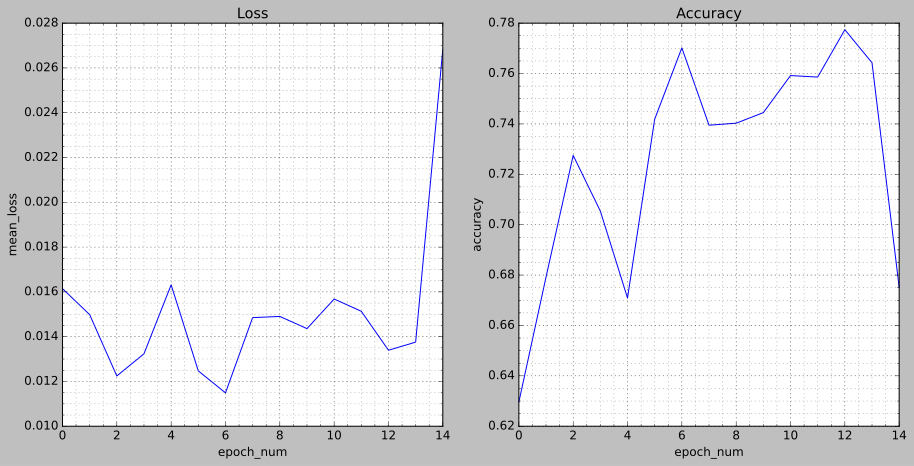

In [45]:
fig = plt.figure(figsize=(15,7))
#plt.title('Кросс-энтропия')

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), loss)
#plt.legend(fontsize = 14)
plt.title("Loss")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), acc)
#plt.legend(fontsize = 14)
plt.title("Accuracy")

plt.show()

## Аугментация

Для аугментации выборки определим случайные преобразования изображений: горизонтальное отображение, вырезание фрагмента, изменение яркости.

In [114]:
#!g1.1
class RandomHorizontalFlip(object):
    def __init__(self, mode=0.5):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        p = random.random()
        if self.method >= p:
            new_img = img.transpose(Image.FLIP_LEFT_RIGHT)
            return new_img
        return img

In [115]:
#!g1.1
class RandomCrop(object):
    def __init__(self, mode=0.5, h=None, w=None):
        self.method = mode
        self.h = h
        self.w = w

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.h is None:
            self.h = random.random() * img.size[1]
        if self.w is None:
            self.w = random.random() * img.size[0]
        area = self.h * self.w
        p = random.random()
        if self.method >= p and area > 10000:
            y = random.random() * (img.size[1] - self.h)
            x = random.random() * (img.size[0] - self.w)
            new_img = img.crop((x, y, x + self.w, y + self.h))
            new_img = new_img.resize((img.size[0], img.size[1]))
            return new_img
        return img

In [116]:
#!g1.1
class ColorBrightness(object):
    def __init__(self, mode=0.5, factor=None):
        self.method = mode
        self.factor = None
        if factor is None:
            self.factor = random.random()
    def __call__(self, img, mask):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        p = random.random()
        if self.method >= p:
            enhancer = ImageEnhance.Brightness(img)
            new_img = enhancer.enhance(self.factor)
            return new_img
        return img

In [117]:
#!g1.1
aug_trasform = transforms.Compose([
    RandomHorizontalFlip(), RandomCrop(), ColorBrightness(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

aug_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_dev_sets = torch.utils.data.ConcatDataset([trainset, aug_trainset])

train_data_loader = DataLoader(train_dev_sets, batch_size=64,
                         shuffle=True, num_workers=2)

Files already downloaded and verified


In [118]:
#!g1.1
resnet_model = ResNet18(num_classes=10)
model = Net(resnet_model)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

val_criterion = IOU
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [119]:
#!g1.1
loss_aug, acc_aug = train(model)

Epoch : 0 mean_loss : 0.013033317637443543 acc : 0.7043
Epoch : 1 mean_loss : 0.012576252761483192 acc : 0.7305
Epoch : 2 mean_loss : 0.01091041455566883 acc : 0.7682
Epoch : 3 mean_loss : 0.012224248474836349 acc : 0.7711
Epoch : 4 mean_loss : 0.014041372615098953 acc : 0.7493
Epoch : 5 mean_loss : 0.012413496509194374 acc : 0.7873
Epoch : 6 mean_loss : 0.011939400041103363 acc : 0.7952
Epoch : 7 mean_loss : 0.012188503256440162 acc : 0.7958
Epoch : 8 mean_loss : 0.013767177012562751 acc : 0.7871
Epoch : 9 mean_loss : 0.01599683153629303 acc : 0.7714
Epoch : 10 mean_loss : 0.013123660871386528 acc : 0.788
Epoch : 11 mean_loss : 0.015585513705015182 acc : 0.7754
Epoch : 12 mean_loss : 0.015299855068325997 acc : 0.7808
Epoch : 13 mean_loss : 0.01262954717874527 acc : 0.805
Epoch : 14 mean_loss : 0.01259684655070305 acc : 0.8058



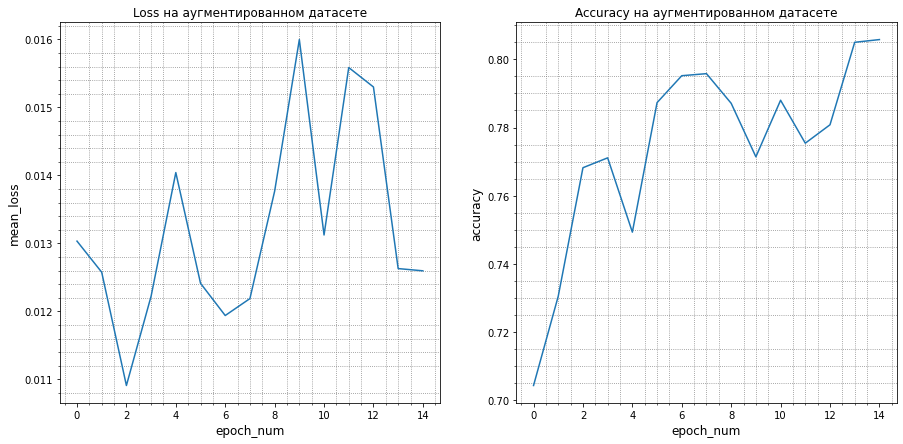

In [120]:
#!g1.1
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), loss_aug)
#plt.legend(fontsize = 14)
plt.title("Loss на аугментированном датасете")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), acc_aug)
#plt.legend(fontsize = 14)
plt.title("Accuracy на аугментированном датасете")

plt.show()

В сравнении с базовым качеством качество на аугментированном датасете стало лучше. Но время обучения закономерно увеличилось в 2 раза. Поэтому использовать аугментацию будем только в финальной модели, на которой достигнется лучшее качество.

## Batch/LR

Сначала отследим, как влияют на время и качество batch_size и learning rate по отдельности, а затем рассмотрим, как они влияют в совокупности.

In [130]:
#!g1.1
batchs = dict()
for i in range(1,5):
    train_data_loader = DataLoader(trainset, batch_size=16*i,
                         shuffle=True, num_workers=2)

    test_data_loader = DataLoader(testset, batch_size=16*i,
                         shuffle=False, num_workers=2)
    resnet_model = ResNet18(num_classes=10)
    model = Net(resnet_model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    print('batch_size =', 16 * i)
    batchs[i] = train(model)

batch_size = 16
Epoch : 0 mean_loss : 0.05567061166316271 acc : 0.6848
Epoch : 1 mean_loss : 0.05111560252010822 acc : 0.7106
Epoch : 2 mean_loss : 0.04022285153120756 acc : 0.778
Epoch : 3 mean_loss : 0.04029344301968813 acc : 0.7794
Epoch : 4 mean_loss : 0.03611638974547386 acc : 0.8021
Epoch : 5 mean_loss : 0.03872015875987708 acc : 0.7983
Epoch : 6 mean_loss : 0.03606035317406058 acc : 0.8158
Epoch : 7 mean_loss : 0.0340178180154413 acc : 0.8199
Epoch : 8 mean_loss : 0.040437108255922796 acc : 0.8035
Epoch : 9 mean_loss : 0.036544820807501675 acc : 0.8267
Epoch : 10 mean_loss : 0.03612187357330695 acc : 0.8287
Epoch : 11 mean_loss : 0.04252903955411166 acc : 0.814
Epoch : 12 mean_loss : 0.04296822076337412 acc : 0.8057
Epoch : 13 mean_loss : 0.039889848462119695 acc : 0.8201
Epoch : 14 mean_loss : 0.04016114666145295 acc : 0.8257

batch_size = 32
Epoch : 0 mean_loss : 0.03534799600243568 acc : 0.6072
Epoch : 1 mean_loss : 0.024486243423819543 acc : 0.7312
Epoch : 2 mean_loss : 0.02

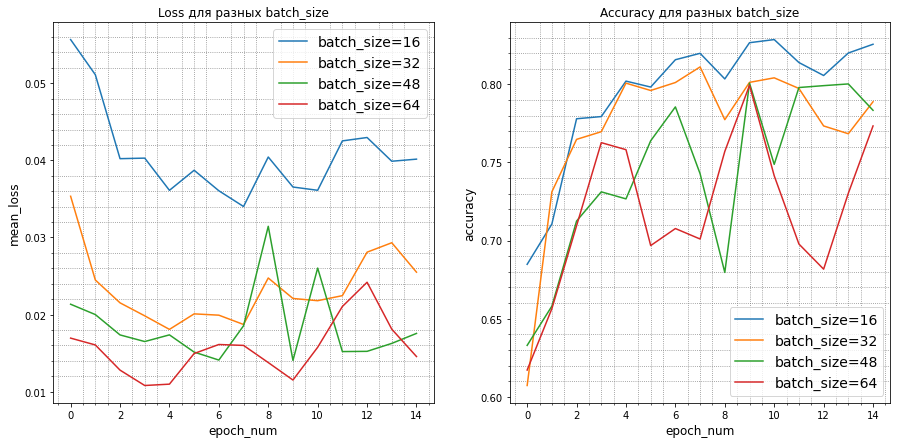

In [132]:
#!g1.1
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(1, 5):
    plt.plot(np.arange(15), batchs[i][0], label='batch_size='+str(i*16))
plt.legend(fontsize = 14)
plt.title("Loss для разных batch_size")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(1, 5):
    plt.plot(np.arange(15), batchs[i][1], label='batch_size='+str(i*16))
plt.legend(fontsize = 14)
plt.title("Accuracy для разных batch_size")

plt.show()

Видно, что в случае больших batch_size происходят скачки на графике, то есть 15 эпох недостаточно для сходимости. Для меньших batch_size резких скачков нет, но время обучения увеличивается. Также, как можно видеть на графике, в случае batch_size=16 большой loss. Вероятно, это можно объяснить тем, что число эпох небольшое. Если взять большее число, то loss может стать меньше.

In [133]:
#!g1.1
train_data_loader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

test_data_loader = DataLoader(testset, batch_size=64,
                         shuffle=False, num_workers=2)

In [135]:
#!g1.1
lrs = dict()
for i in range(1,5):
    resnet_model = ResNet18(num_classes=10)
    model = Net(resnet_model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=1/(10**i), weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    print('learning rate =', 1/(10**i))
    lrs[i] = train(model)

learning rate = 0.1
Epoch : 0 mean_loss : 0.05084697709083557 acc : 0.122
Epoch : 1 mean_loss : 0.03160132750272751 acc : 0.2392
Epoch : 2 mean_loss : 0.031526025557518 acc : 0.273
Epoch : 3 mean_loss : 0.03845820811986923 acc : 0.2515
Epoch : 4 mean_loss : 0.028781345021724702 acc : 0.2718
Epoch : 5 mean_loss : 0.06489718389511108 acc : 0.1391
Epoch : 6 mean_loss : 0.868590873336792 acc : 0.1
Epoch : 7 mean_loss : 0.05938505010604858 acc : 0.1616
Epoch : 8 mean_loss : 0.2838338172912598 acc : 0.1588
Epoch : 9 mean_loss : 0.03825788879394531 acc : 0.1953
Epoch : 10 mean_loss : 0.1780505048274994 acc : 0.1182
Epoch : 11 mean_loss : 0.18925365753173828 acc : 0.1002
Epoch : 12 mean_loss : 0.053255969977378845 acc : 0.1129
Epoch : 13 mean_loss : 0.0908250761270523 acc : 0.1979
Epoch : 14 mean_loss : 0.0409158714056015 acc : 0.1296

learning rate = 0.01
Epoch : 0 mean_loss : 0.02749634989500046 acc : 0.3566
Epoch : 1 mean_loss : 0.020392146837711334 acc : 0.5183
Epoch : 2 mean_loss : 0.0201

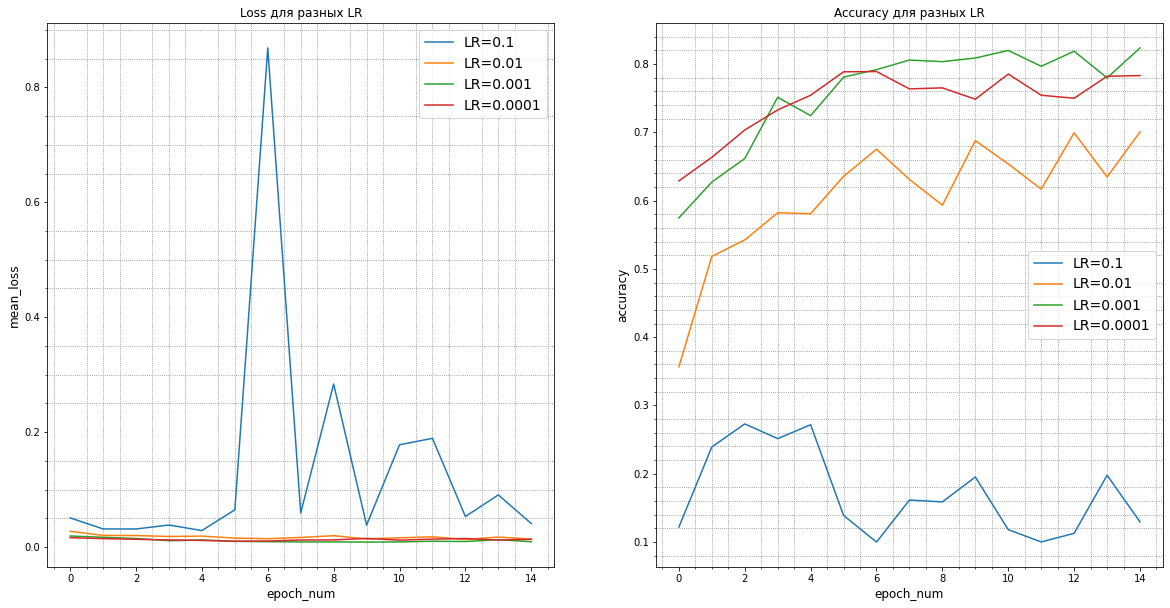

In [137]:
#!g1.1
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(1, 5):
    plt.plot(np.arange(15), lrs[i][0], label='LR='+str(1/(10**i)))
plt.legend(fontsize = 14)
plt.title("Loss для разных LR")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(1, 5):
    plt.plot(np.arange(15), lrs[i][1], label='LR='+str(1/(10**i)))
plt.legend(fontsize = 14)
plt.title("Accuracy для разных LR")

plt.show()

Ожидаемо при меньших значениях learning rate точность выше и сходимость лучше, в то время как при больших получаем совсем невысокое качество и худшую сходимость.

In [138]:
#!g1.1
b_lr = dict()
for i in range(1,5):
    train_data_loader = DataLoader(trainset, batch_size=16*(5 - i),
                         shuffle=True, num_workers=2)

    test_data_loader = DataLoader(testset, batch_size=16*(5 - i),
                         shuffle=False, num_workers=2)
    resnet_model = ResNet18(num_classes=10)
    model = Net(resnet_model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=1/(10**i), weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    print('batch_size =', 16*(5 - i), ' LR =', 1/(10**i))
    b_lr[i] = train(model)

batch_size = 64  LR = 0.1
Epoch : 0 mean_loss : 0.03278358020782471 acc : 0.1838
Epoch : 1 mean_loss : 0.040682102370262145 acc : 0.1139
Epoch : 2 mean_loss : 0.0559501953125 acc : 0.1458
Epoch : 3 mean_loss : 0.03306570073366165 acc : 0.218
Epoch : 4 mean_loss : 0.03529186784029007 acc : 0.2017
Epoch : 5 mean_loss : 0.03134735993146896 acc : 0.2474
Epoch : 6 mean_loss : 0.04180278058052063 acc : 0.1984
Epoch : 7 mean_loss : 0.035055190908908844 acc : 0.1875
Epoch : 8 mean_loss : 0.05864906907081604 acc : 0.1298
Epoch : 9 mean_loss : 0.0832573965549469 acc : 0.1001
Epoch : 10 mean_loss : 0.2935970133781433 acc : 0.1386
Epoch : 11 mean_loss : 0.03668008489608764 acc : 0.1588
Epoch : 12 mean_loss : 0.06264364478588104 acc : 0.1026
Epoch : 13 mean_loss : 0.03237700599431992 acc : 0.2909
Epoch : 14 mean_loss : 0.036184021425247195 acc : 0.1639

batch_size = 48  LR = 0.01
Epoch : 0 mean_loss : 0.036808657109737394 acc : 0.3773
Epoch : 1 mean_loss : 0.029988810616731643 acc : 0.5133
Epoch : 

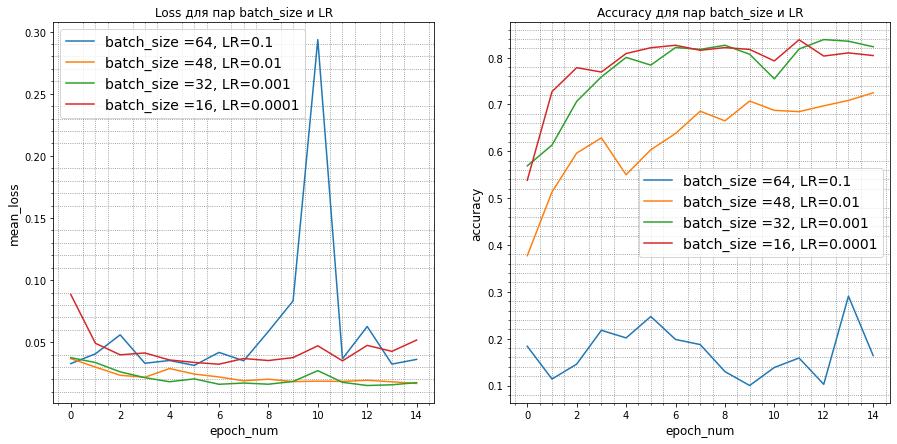

In [144]:
#!g1.1
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(1, 5):
    plt.plot(np.arange(15), b_lr[i][0], label='batch_size =' + str(16*(5 - i)) + ', LR='+str(1/(10**i)))
plt.legend(fontsize = 14)
plt.title("Loss для пар batch_size и LR")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for i in range(1, 5):
    plt.plot(np.arange(15), b_lr[i][1], label='batch_size =' + str(16*(5 - i)) + ', LR='+str(1/(10**i)))
plt.legend(fontsize = 14)
plt.title("Accuracy для пар batch_size и LR")

plt.show()

Рассматренные в совокупности значения batch_size и learning rate показали примерно такие же результаты, как и по отдельности. Что имеет смысл отметить: небольшой learning rate обеспечивает небольшое число скачков на графике, то есть лучшую сходимость. Но если зафиксировать только его, а batch_size брать большим, то качество может оказаться чуть хуже. Для финальной модели возьмем batch_size=16, LR=0.0001. В дальнейших экспериментах оставим уже зафиксированные значения, чтобы не увеличивать время вычислений.

## Оптимизатор

Оптимизаторов в pytorch больше, чем 4, но здесь рассмотрим 4 самых популярных: Adam, SGD, RMSProp, Momentum.

In [145]:
#!g1.1
train_data_loader = DataLoader(trainset, batch_size=64,
                         shuffle=True, num_workers=2)

test_data_loader = DataLoader(testset, batch_size=64,
                         shuffle=False, num_workers=2)

In [146]:
#!g1.1
opts = {'Adam': optim.Adam, \
        'SGD': optim.SGD, \
        'RMSProp': optim.RMSprop, \
        'Momentum': optim.SGD
       }

In [147]:
#!g1.1
opts_res = dict()
for key in opts:
    resnet_model = ResNet18(num_classes=10)
    model = Net(resnet_model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if key != 'Momentum':
        optimizer = opts[key](model.parameters(), lr=0.0001, weight_decay=weight_decay)
    else:
        optimizer = opts[key](model.parameters(), lr=0.0001, weight_decay=weight_decay, momentum=0.8)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    print('optimizer =', key)
    opts_res[key] = train(model)

optimizer = Adam


Epoch : 0 mean_loss : 0.017569049841165543 acc : 0.607
Epoch : 1 mean_loss : 0.01568214420080185 acc : 0.6519
Epoch : 2 mean_loss : 0.01105060623884201 acc : 0.7528
Epoch : 3 mean_loss : 0.01054908075928688 acc : 0.7686
Epoch : 4 mean_loss : 0.013386426973342896 acc : 0.7177
Epoch : 5 mean_loss : 0.009304335272312165 acc : 0.8013
Epoch : 6 mean_loss : 0.010923776683211327 acc : 0.7812
Epoch : 7 mean_loss : 0.012023149985074998 acc : 0.7662
Epoch : 8 mean_loss : 0.013897314915060997 acc : 0.757
Epoch : 9 mean_loss : 0.014491037786006928 acc : 0.7577
Epoch : 10 mean_loss : 0.014983398592472077 acc : 0.7416
Epoch : 11 mean_loss : 0.013641274872422218 acc : 0.7749
Epoch : 12 mean_loss : 0.013576884523034096 acc : 0.7685
Epoch : 13 mean_loss : 0.014179974353313446 acc : 0.7659
Epoch : 14 mean_loss : 0.01651543336212635 acc : 0.7448

optimizer = SGD


Epoch : 0 mean_loss : 0.0341863094329834 acc : 0.2457
Epoch : 1 mean_loss : 0.03249379941225052 acc : 0.2865
Epoch : 2 mean_loss : 0.0310867862701416 acc : 0.3091
Epoch : 3 mean_loss : 0.03011977822780609 acc : 0.3208
Epoch : 4 mean_loss : 0.029342748045921324 acc : 0.3395
Epoch : 5 mean_loss : 0.02859174633026123 acc : 0.3556
Epoch : 6 mean_loss : 0.028032691562175752 acc : 0.3663
Epoch : 7 mean_loss : 0.027452835166454314 acc : 0.377
Epoch : 8 mean_loss : 0.0270295333981514 acc : 0.3875
Epoch : 9 mean_loss : 0.026578827238082886 acc : 0.3953
Epoch : 10 mean_loss : 0.026216022670269012 acc : 0.4051
Epoch : 11 mean_loss : 0.025846690165996552 acc : 0.4123
Epoch : 12 mean_loss : 0.025574229097366334 acc : 0.4193
Epoch : 13 mean_loss : 0.025251327908039092 acc : 0.423
Epoch : 14 mean_loss : 0.02489122792482376 acc : 0.43

optimizer = RMSProp


Epoch : 0 mean_loss : 0.0266410826086998 acc : 0.4621
Epoch : 1 mean_loss : 0.015033653628826141 acc : 0.6454
Epoch : 2 mean_loss : 0.015538066130876542 acc : 0.6709
Epoch : 3 mean_loss : 0.018424613028764726 acc : 0.6073
Epoch : 4 mean_loss : 0.01898969604372978 acc : 0.6452
Epoch : 5 mean_loss : 0.017496378695964813 acc : 0.6731
Epoch : 6 mean_loss : 0.014037164902687072 acc : 0.7401
Epoch : 7 mean_loss : 0.03407297625541687 acc : 0.6075
Epoch : 8 mean_loss : 0.02082938884496689 acc : 0.6831
Epoch : 9 mean_loss : 0.0527711407661438 acc : 0.4062
Epoch : 10 mean_loss : 0.02121216399669647 acc : 0.6948
Epoch : 11 mean_loss : 0.07091890535354614 acc : 0.4323
Epoch : 12 mean_loss : 0.012128046667575837 acc : 0.7869
Epoch : 13 mean_loss : 0.03237469198703766 acc : 0.6489
Epoch : 14 mean_loss : 0.018080168360471726 acc : 0.7059

optimizer = Momentum


Epoch : 0 mean_loss : 0.02883092494010925 acc : 0.3433
Epoch : 1 mean_loss : 0.02646202749013901 acc : 0.3911
Epoch : 2 mean_loss : 0.025100696218013762 acc : 0.4249
Epoch : 3 mean_loss : 0.023817546451091767 acc : 0.4553
Epoch : 4 mean_loss : 0.023379123961925506 acc : 0.4609
Epoch : 5 mean_loss : 0.02189702810049057 acc : 0.5048
Epoch : 6 mean_loss : 0.020821359634399413 acc : 0.5274
Epoch : 7 mean_loss : 0.020702674901485443 acc : 0.5234
Epoch : 8 mean_loss : 0.019450189930200576 acc : 0.5552
Epoch : 9 mean_loss : 0.0195700903236866 acc : 0.5614
Epoch : 10 mean_loss : 0.01877848422527313 acc : 0.5731
Epoch : 11 mean_loss : 0.018202903538942338 acc : 0.592
Epoch : 12 mean_loss : 0.01784682229757309 acc : 0.5956
Epoch : 13 mean_loss : 0.018126705664396284 acc : 0.5874
Epoch : 14 mean_loss : 0.017504485684633257 acc : 0.6041



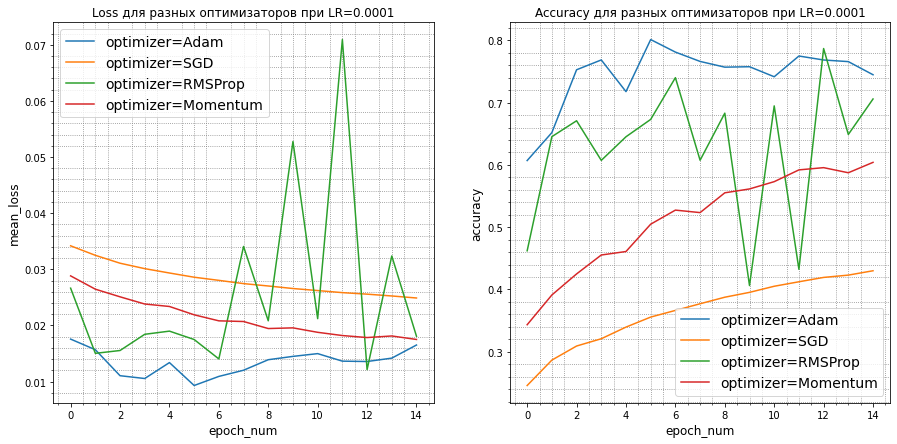

In [148]:
#!g1.1
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for key in opts:
    plt.plot(np.arange(15), opts_res[key][0], label='optimizer='+key)
plt.legend(fontsize = 14)
plt.title("Loss для разных оптимизаторов при LR=0.0001")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for key in opts:
    plt.plot(np.arange(15), opts_res[key][1], label='optimizer='+key)
plt.legend(fontsize = 14)
plt.title("Accuracy для разных оптимизаторов при LR=0.0001")

plt.show()

Видно, что лучшие результаты показывает Adam. Скорее всего, это связано со значением LR или числом эпох. В случае RMSProp нет сходимости, а это значит, что надо уменьшить LR (лучше) или увеличить число эпох. В случае SGD и Momentum видно, что качество растет от эпохи к эпохе, скачков нет, но на плато качеству выйти не удается. А значит, опять нужно увеличить число эпох. Но тогда нейросеть будет обучаться дольше, а хотелось бы этого избежать. Поэтому остановимся на оптимизаторе Adam.

## Программатор

Реализация взята отсюда с некоторыми изменениями: https://russianblogs.com/article/7461549295/. На каждой эпохе мы уменьшаем LR в некоторое заданное число раз (1 - шаг остается без изменений).

In [162]:
#!g1.1
def adjust_learning_rate(optimizer, d):
    for param_group in optimizer.param_groups:
        if param_group['lr'] > 0.0001:
            param_group['lr'] /= d

In [164]:
#!g1.1
dd = np.arange(1, 6)
progr_res = dict()
for d in dd:
    resnet_model = ResNet18(num_classes=10)
    model = Net(resnet_model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if d != 1:
        optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    print('d =', d)
    progr_res[d] = train(model, progr=d)

d = 1


Epoch : 0 mean_loss : 0.017936844807863235 acc : 0.5901
Epoch : 1 mean_loss : 0.014057488399744035 acc : 0.6808
Epoch : 2 mean_loss : 0.014218286168575288 acc : 0.6965
Epoch : 3 mean_loss : 0.010779691579937935 acc : 0.7637
Epoch : 4 mean_loss : 0.010586771765351296 acc : 0.771
Epoch : 5 mean_loss : 0.011205909463763236 acc : 0.7736
Epoch : 6 mean_loss : 0.00985465953350067 acc : 0.7931
Epoch : 7 mean_loss : 0.012387694096565247 acc : 0.7679
Epoch : 8 mean_loss : 0.01113976833820343 acc : 0.788
Epoch : 9 mean_loss : 0.01298542558848858 acc : 0.778
Epoch : 10 mean_loss : 0.015849614959955214 acc : 0.7461
Epoch : 11 mean_loss : 0.015559761682152748 acc : 0.7491
Epoch : 12 mean_loss : 0.013755600392818451 acc : 0.7742
Epoch : 13 mean_loss : 0.01263216315805912 acc : 0.7865
Epoch : 14 mean_loss : 0.012908632177114486 acc : 0.7808

d = 2


Epoch : 0 mean_loss : 0.036846231818199154 acc : 0.2377
Epoch : 1 mean_loss : 0.030662430024147033 acc : 0.2644
Epoch : 2 mean_loss : 0.035138523173332215 acc : 0.2376
Epoch : 3 mean_loss : 0.030006579566001893 acc : 0.2888
Epoch : 4 mean_loss : 0.02456624150276184 acc : 0.39
Epoch : 5 mean_loss : 0.02620527721643448 acc : 0.4
Epoch : 6 mean_loss : 0.023433949887752534 acc : 0.4534
Epoch : 7 mean_loss : 0.022639182245731353 acc : 0.4676
Epoch : 8 mean_loss : 0.02092224156856537 acc : 0.5095
Epoch : 9 mean_loss : 0.02242453052997589 acc : 0.48
Epoch : 10 mean_loss : 0.020423693943023683 acc : 0.519
Epoch : 11 mean_loss : 0.020481015527248382 acc : 0.5155
Epoch : 12 mean_loss : 0.019972166126966475 acc : 0.5304
Epoch : 13 mean_loss : 0.01922305616736412 acc : 0.5498
Epoch : 14 mean_loss : 0.019435659283399583 acc : 0.5489

d = 3


Epoch : 0 mean_loss : 0.03407214123010635 acc : 0.1938
Epoch : 1 mean_loss : 0.03018736262321472 acc : 0.3348
Epoch : 2 mean_loss : 0.029153470361232756 acc : 0.3191
Epoch : 3 mean_loss : 0.021703279626369476 acc : 0.4823
Epoch : 4 mean_loss : 0.023981110739707948 acc : 0.4411
Epoch : 5 mean_loss : 0.019604044622182844 acc : 0.5426
Epoch : 6 mean_loss : 0.01865904223918915 acc : 0.5716
Epoch : 7 mean_loss : 0.017455735808610918 acc : 0.5979
Epoch : 8 mean_loss : 0.017238704872131347 acc : 0.5966
Epoch : 9 mean_loss : 0.016657438546419143 acc : 0.6094
Epoch : 10 mean_loss : 0.016526839607954025 acc : 0.6147
Epoch : 11 mean_loss : 0.016352718102931978 acc : 0.6198
Epoch : 12 mean_loss : 0.01633331662416458 acc : 0.6191
Epoch : 13 mean_loss : 0.016260814797878265 acc : 0.6199
Epoch : 14 mean_loss : 0.016247469741106035 acc : 0.6246

d = 4


Epoch : 0 mean_loss : 0.03498099944591522 acc : 0.1718
Epoch : 1 mean_loss : 0.027326726293563842 acc : 0.331
Epoch : 2 mean_loss : 0.026241405272483826 acc : 0.3632
Epoch : 3 mean_loss : 0.023219707942008973 acc : 0.4311
Epoch : 4 mean_loss : 0.022085232603549956 acc : 0.4668
Epoch : 5 mean_loss : 0.02066730889081955 acc : 0.5025
Epoch : 6 mean_loss : 0.019889721298217772 acc : 0.5272
Epoch : 7 mean_loss : 0.019380476248264313 acc : 0.5381
Epoch : 8 mean_loss : 0.01921165406703949 acc : 0.5481
Epoch : 9 mean_loss : 0.019091913211345672 acc : 0.5495
Epoch : 10 mean_loss : 0.01902763914465904 acc : 0.5518
Epoch : 11 mean_loss : 0.01899379925131798 acc : 0.5538
Epoch : 12 mean_loss : 0.018843812149763106 acc : 0.5589
Epoch : 13 mean_loss : 0.01877873842716217 acc : 0.5609
Epoch : 14 mean_loss : 0.01868916624188423 acc : 0.5644

d = 5


Epoch : 0 mean_loss : 0.04777723212242126 acc : 0.1508
Epoch : 1 mean_loss : 0.027094705617427824 acc : 0.3547
Epoch : 2 mean_loss : 0.03484362596273422 acc : 0.3082
Epoch : 3 mean_loss : 0.024404500305652617 acc : 0.4271
Epoch : 4 mean_loss : 0.02094995696544647 acc : 0.5056
Epoch : 5 mean_loss : 0.020180319607257843 acc : 0.5157
Epoch : 6 mean_loss : 0.019852447521686554 acc : 0.5245
Epoch : 7 mean_loss : 0.01877885817885399 acc : 0.5511
Epoch : 8 mean_loss : 0.018603095072507857 acc : 0.5586
Epoch : 9 mean_loss : 0.01847258151769638 acc : 0.5639
Epoch : 10 mean_loss : 0.018424690318107603 acc : 0.5655
Epoch : 11 mean_loss : 0.018401964199543 acc : 0.5648
Epoch : 12 mean_loss : 0.018338716506958008 acc : 0.5649
Epoch : 13 mean_loss : 0.018367502671480178 acc : 0.5653
Epoch : 14 mean_loss : 0.01823719453215599 acc : 0.5694



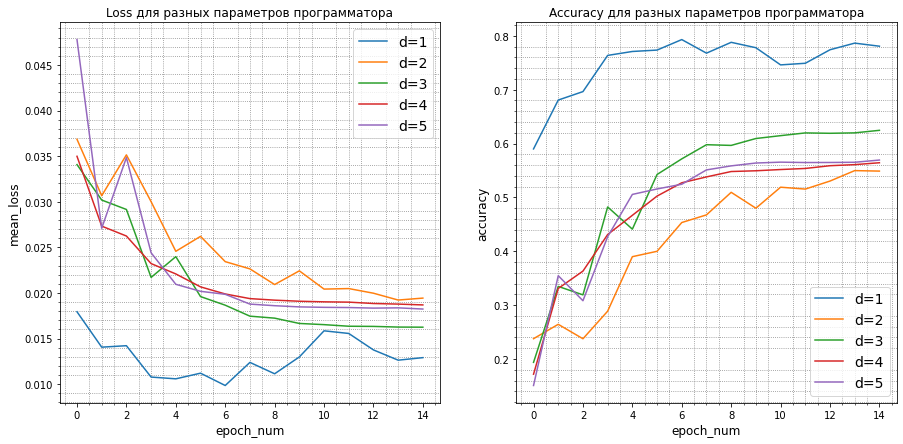

In [165]:
#!g1.1
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for d in dd:
    plt.plot(np.arange(15), progr_res[d][0], label='d='+str(d))
plt.legend(fontsize = 14)
plt.title("Loss для разных параметров программатора")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for d in dd:
    plt.plot(np.arange(15), progr_res[d][1], label='d='+str(d))
plt.legend(fontsize = 14)
plt.title("Accuracy для разных параметров программатора")

plt.show()

Вероятно, это оказался плохой программатор, потому что качество с его использованием стало хуже. В финальной версии его использовать не станем.

## Gradient clipping

Рассмотрим случаи, когда градиент обрезается в случае, когда его норма больше 1, 2, 5, 7 и 10.

In [174]:
#!g1.1
max_norms = [1, 2, 5, 7, 10]
mn_res = dict()
for m in max_norms:
    resnet_model = ResNet18(num_classes=10)
    model = Net(resnet_model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    print('max_norm =', m)
    mn_res[m] = train(model, max_norm=m)

max_norm = 1


Epoch : 0 mean_loss : 0.01767573533654213 acc : 0.6038
Epoch : 1 mean_loss : 0.014218027299642564 acc : 0.6817
Epoch : 2 mean_loss : 0.013904206019639969 acc : 0.6876
Epoch : 3 mean_loss : 0.01661150315403938 acc : 0.6538
Epoch : 4 mean_loss : 0.013133340883255004 acc : 0.7203
Epoch : 5 mean_loss : 0.0135154675334692 acc : 0.7214
Epoch : 6 mean_loss : 0.014937644678354263 acc : 0.7004
Epoch : 7 mean_loss : 0.013218719097971916 acc : 0.744
Epoch : 8 mean_loss : 0.012147985151410103 acc : 0.7702
Epoch : 9 mean_loss : 0.010731379967927933 acc : 0.788
Epoch : 10 mean_loss : 0.01421258915066719 acc : 0.7647
Epoch : 11 mean_loss : 0.011396211722493171 acc : 0.7874
Epoch : 12 mean_loss : 0.01397080928683281 acc : 0.7551
Epoch : 13 mean_loss : 0.011699392068386077 acc : 0.7866
Epoch : 14 mean_loss : 0.01205382018685341 acc : 0.7837

max_norm = 2


Epoch : 0 mean_loss : 0.01823989337682724 acc : 0.5807
Epoch : 1 mean_loss : 0.016105648362636567 acc : 0.6336
Epoch : 2 mean_loss : 0.015205929070711137 acc : 0.659
Epoch : 3 mean_loss : 0.010945498409867287 acc : 0.7615
Epoch : 4 mean_loss : 0.01764029410481453 acc : 0.6496
Epoch : 5 mean_loss : 0.014413152834773063 acc : 0.7229
Epoch : 6 mean_loss : 0.01523348165154457 acc : 0.7247
Epoch : 7 mean_loss : 0.011050683571398259 acc : 0.7831
Epoch : 8 mean_loss : 0.010643013525009156 acc : 0.7948
Epoch : 9 mean_loss : 0.012580009931325912 acc : 0.7744
Epoch : 10 mean_loss : 0.014393372792005539 acc : 0.7558
Epoch : 11 mean_loss : 0.012764400938153267 acc : 0.7855
Epoch : 12 mean_loss : 0.011273480594158173 acc : 0.7963
Epoch : 13 mean_loss : 0.014795274007320404 acc : 0.7685
Epoch : 14 mean_loss : 0.012171754536032676 acc : 0.7931

max_norm = 5


Epoch : 0 mean_loss : 0.018703540569543837 acc : 0.5734
Epoch : 1 mean_loss : 0.014892313253879547 acc : 0.6609
Epoch : 2 mean_loss : 0.013741283690929413 acc : 0.6877
Epoch : 3 mean_loss : 0.010915194162726403 acc : 0.7592
Epoch : 4 mean_loss : 0.009088339692354203 acc : 0.7992
Epoch : 5 mean_loss : 0.010357144102454186 acc : 0.7818
Epoch : 6 mean_loss : 0.013988425707817078 acc : 0.7323
Epoch : 7 mean_loss : 0.012900718149542809 acc : 0.7421
Epoch : 8 mean_loss : 0.013764901244640351 acc : 0.7522
Epoch : 9 mean_loss : 0.013342909559607506 acc : 0.7703
Epoch : 10 mean_loss : 0.014128456589579582 acc : 0.7695
Epoch : 11 mean_loss : 0.014667665827274322 acc : 0.7569
Epoch : 12 mean_loss : 0.014870707505941392 acc : 0.7653
Epoch : 13 mean_loss : 0.012929433959722519 acc : 0.7912
Epoch : 14 mean_loss : 0.012468613675236702 acc : 0.7917

max_norm = 7


Epoch : 0 mean_loss : 0.016802987837791442 acc : 0.6176
Epoch : 1 mean_loss : 0.014562512814998627 acc : 0.6651
Epoch : 2 mean_loss : 0.012313733914494515 acc : 0.7275
Epoch : 3 mean_loss : 0.011660126724839211 acc : 0.7477
Epoch : 4 mean_loss : 0.012470310226082802 acc : 0.7277
Epoch : 5 mean_loss : 0.010895706716179848 acc : 0.7612
Epoch : 6 mean_loss : 0.013790012848377229 acc : 0.7314
Epoch : 7 mean_loss : 0.010661361256241798 acc : 0.7881
Epoch : 8 mean_loss : 0.014586411726474763 acc : 0.7471
Epoch : 9 mean_loss : 0.015775973856449126 acc : 0.7373
Epoch : 10 mean_loss : 0.013584440383315086 acc : 0.7867
Epoch : 11 mean_loss : 0.015376373508572579 acc : 0.7478
Epoch : 12 mean_loss : 0.01460594457089901 acc : 0.7516
Epoch : 13 mean_loss : 0.014646565595269204 acc : 0.7597
Epoch : 14 mean_loss : 0.015517872706055641 acc : 0.7774

max_norm = 10


Epoch : 0 mean_loss : 0.016451257795095445 acc : 0.6331
Epoch : 1 mean_loss : 0.013607190501689912 acc : 0.6957
Epoch : 2 mean_loss : 0.013647040447592735 acc : 0.6988
Epoch : 3 mean_loss : 0.011724512764811516 acc : 0.7403
Epoch : 4 mean_loss : 0.01380392237007618 acc : 0.7128
Epoch : 5 mean_loss : 0.01391984296143055 acc : 0.7302
Epoch : 6 mean_loss : 0.015963241982460023 acc : 0.7112
Epoch : 7 mean_loss : 0.011570775216817855 acc : 0.7764
Epoch : 8 mean_loss : 0.016055625551939012 acc : 0.7116
Epoch : 9 mean_loss : 0.01297484590113163 acc : 0.7747
Epoch : 10 mean_loss : 0.01403561324775219 acc : 0.7625
Epoch : 11 mean_loss : 0.012730385902523995 acc : 0.7818
Epoch : 12 mean_loss : 0.01346415251493454 acc : 0.7716
Epoch : 13 mean_loss : 0.015578906765580177 acc : 0.7502
Epoch : 14 mean_loss : 0.01778586295247078 acc : 0.7289



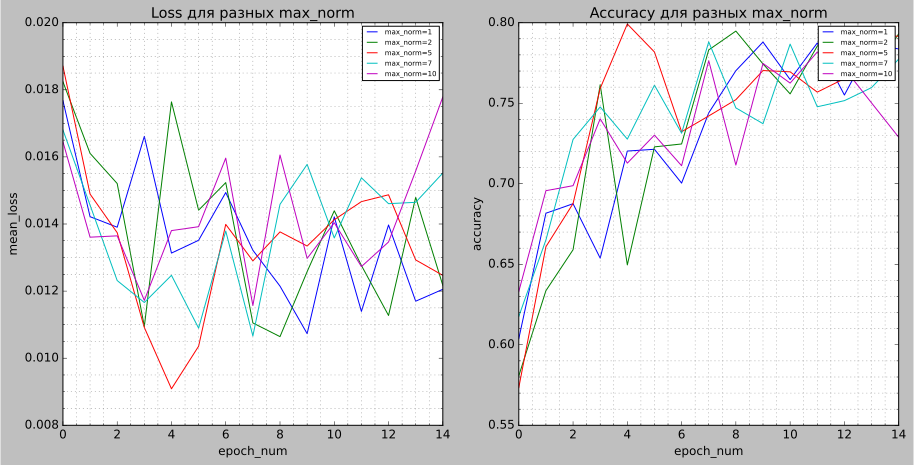

In [182]:
#!g1.1
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for m in max_norms:
    plt.plot(np.arange(15), mn_res[m][0], label='max_norm='+str(m))
plt.legend(fontsize = 7)
plt.title("Loss для разных max_norm")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for m in max_norms:
    plt.plot(np.arange(15), mn_res[m][1], label='max_norm='+str(m))
plt.legend(fontsize = 7)
plt.title("Accuracy для разных max_norm")

plt.show()

Видно, что использование Gradient Clipping сильно ухудшает сходимость. Поэтому в финальной версии не будем его использовать.

## Регуляризация

Сначала рассмотрим l1 регуляризацию.

In [184]:
#!g1.1
l1_res = dict()
for w in weights:
    resnet_model = ResNet18(num_classes=10)
    model = Net(resnet_model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    print('weight_decay =', w)
    l1_res[w] = train(model, l1=w)

weight_decay = 1e-05


Epoch : 0 mean_loss : 0.016433009964227675 acc : 0.6253
Epoch : 1 mean_loss : 0.013501813018321991 acc : 0.6914
Epoch : 2 mean_loss : 0.010833439186215401 acc : 0.7497
Epoch : 3 mean_loss : 0.013156002676486969 acc : 0.7298
Epoch : 4 mean_loss : 0.012282269379496575 acc : 0.7388
Epoch : 5 mean_loss : 0.01527924330830574 acc : 0.7225
Epoch : 6 mean_loss : 0.010517365118861198 acc : 0.7907
Epoch : 7 mean_loss : 0.014098075303435325 acc : 0.7319
Epoch : 8 mean_loss : 0.019650070977211 acc : 0.6948
Epoch : 9 mean_loss : 0.011801053991913795 acc : 0.7753
Epoch : 10 mean_loss : 0.015351351511478425 acc : 0.7366
Epoch : 11 mean_loss : 0.01697881858944893 acc : 0.7266
Epoch : 12 mean_loss : 0.020095748502016068 acc : 0.7036
Epoch : 13 mean_loss : 0.019844266653060914 acc : 0.7123
Epoch : 14 mean_loss : 0.0262114819675684 acc : 0.6625

weight_decay = 0.0001


Epoch : 0 mean_loss : 0.020154973989725114 acc : 0.5457
Epoch : 1 mean_loss : 0.015407767355442047 acc : 0.6583
Epoch : 2 mean_loss : 0.014430458152294158 acc : 0.6721
Epoch : 3 mean_loss : 0.014776685237884522 acc : 0.6719
Epoch : 4 mean_loss : 0.013772153174877167 acc : 0.693
Epoch : 5 mean_loss : 0.012826661545038223 acc : 0.7242
Epoch : 6 mean_loss : 0.02291837050318718 acc : 0.5852
Epoch : 7 mean_loss : 0.011111219576001167 acc : 0.7552
Epoch : 8 mean_loss : 0.012741153982281685 acc : 0.7434
Epoch : 9 mean_loss : 0.012235573446750641 acc : 0.752
Epoch : 10 mean_loss : 0.02139965769648552 acc : 0.6464
Epoch : 11 mean_loss : 0.010737655237317085 acc : 0.7861
Epoch : 12 mean_loss : 0.010942419460415841 acc : 0.7759
Epoch : 13 mean_loss : 0.015514103046059609 acc : 0.739
Epoch : 14 mean_loss : 0.016117707726359367 acc : 0.7231

weight_decay = 0.001


Epoch : 0 mean_loss : 0.022472559666633606 acc : 0.4715
Epoch : 1 mean_loss : 0.020457845622301102 acc : 0.5562
Epoch : 2 mean_loss : 0.023712260019779205 acc : 0.4947
Epoch : 3 mean_loss : 0.028467656230926515 acc : 0.43
Epoch : 4 mean_loss : 0.017739540898799897 acc : 0.6032
Epoch : 5 mean_loss : 0.01622020029425621 acc : 0.6318
Epoch : 6 mean_loss : 0.015360608345270158 acc : 0.644
Epoch : 7 mean_loss : 0.015972317135334015 acc : 0.6466
Epoch : 8 mean_loss : 0.01532547169327736 acc : 0.6489
Epoch : 9 mean_loss : 0.015562627571821213 acc : 0.6453
Epoch : 10 mean_loss : 0.022590830969810485 acc : 0.5713
Epoch : 11 mean_loss : 0.02298324036002159 acc : 0.5617
Epoch : 12 mean_loss : 0.014044658273458481 acc : 0.6841
Epoch : 13 mean_loss : 0.015521919023990631 acc : 0.6612
Epoch : 14 mean_loss : 0.014110657066106796 acc : 0.6876

weight_decay = 0.01


Epoch : 0 mean_loss : 0.031558211016654965 acc : 0.2554
Epoch : 1 mean_loss : 0.08283112542629242 acc : 0.1813
Epoch : 2 mean_loss : 0.03203983141183853 acc : 0.3088
Epoch : 3 mean_loss : 0.03533029522895813 acc : 0.2845
Epoch : 4 mean_loss : 0.024046500599384308 acc : 0.4476
Epoch : 5 mean_loss : 0.02350160834789276 acc : 0.4929
Epoch : 6 mean_loss : 0.022330976021289826 acc : 0.4977
Epoch : 7 mean_loss : 0.023477007603645326 acc : 0.4548
Epoch : 8 mean_loss : 0.02298244514465332 acc : 0.4633
Epoch : 9 mean_loss : 0.02469125133752823 acc : 0.4484
Epoch : 10 mean_loss : 0.023574364829063416 acc : 0.4599
Epoch : 11 mean_loss : 0.024935009729862213 acc : 0.5241
Epoch : 12 mean_loss : 0.02604101617336273 acc : 0.5349
Epoch : 13 mean_loss : 0.025462323343753816 acc : 0.5068
Epoch : 14 mean_loss : 0.024619210577011108 acc : 0.5284



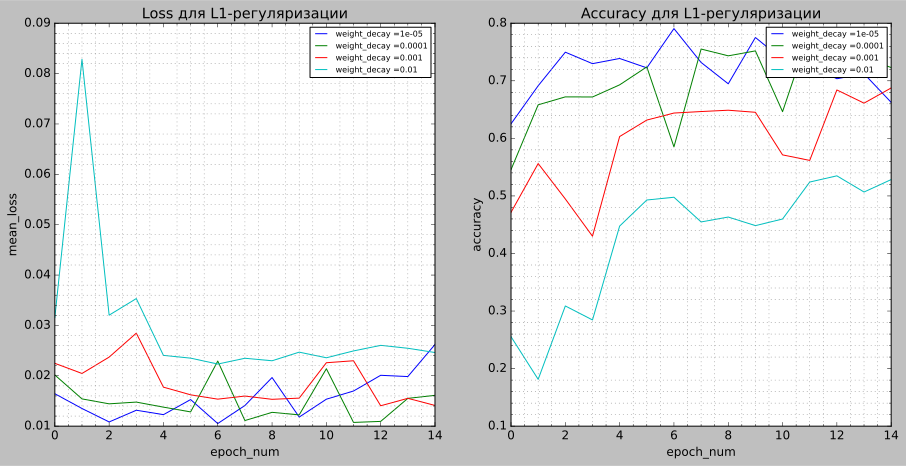

In [187]:
#!g1.1
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for w in weights:
    plt.plot(np.arange(15), l1_res[w][0], label='weight_decay ='+str(w))
plt.legend(fontsize = 8)
plt.title("Loss для L1-регуляризации")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for w in weights:
    plt.plot(np.arange(15), l1_res[w][1], label='weight_decay ='+str(w))
plt.legend(fontsize = 8)
plt.title("Accuracy для L1-регуляризации")

plt.show()

Теперь рассмотрим L2-регуляризацию с теми же коэффициентами

In [167]:
#!g1.1
l2_res = dict()
for w in weights:
    resnet_model = ResNet18(num_classes=10)
    model = Net(resnet_model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=w)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    print('weight_decay =', w)
    l2_res[w] = train(model)

weight_decay = 1e-05


Epoch : 0 mean_loss : 0.017315332847833632 acc : 0.5984
Epoch : 1 mean_loss : 0.013972227090597153 acc : 0.69
Epoch : 2 mean_loss : 0.013963591253757476 acc : 0.6825
Epoch : 3 mean_loss : 0.01156031633913517 acc : 0.7455
Epoch : 4 mean_loss : 0.012640993657708169 acc : 0.7321
Epoch : 5 mean_loss : 0.010673274919390678 acc : 0.7771
Epoch : 6 mean_loss : 0.011818000641465187 acc : 0.7582
Epoch : 7 mean_loss : 0.012723144146800041 acc : 0.7696
Epoch : 8 mean_loss : 0.019391223061084747 acc : 0.6981
Epoch : 9 mean_loss : 0.011030050081014634 acc : 0.7928
Epoch : 10 mean_loss : 0.014142240124940872 acc : 0.7558
Epoch : 11 mean_loss : 0.01661737876534462 acc : 0.7454
Epoch : 12 mean_loss : 0.01573985105752945 acc : 0.7511
Epoch : 13 mean_loss : 0.012393674710392951 acc : 0.7842
Epoch : 14 mean_loss : 0.017025205796957016 acc : 0.7571

weight_decay = 0.0001


Epoch : 0 mean_loss : 0.017905850714445115 acc : 0.5989
Epoch : 1 mean_loss : 0.015394412887096405 acc : 0.6542
Epoch : 2 mean_loss : 0.01219037014245987 acc : 0.7271
Epoch : 3 mean_loss : 0.01633031120300293 acc : 0.6634
Epoch : 4 mean_loss : 0.0133021748483181 acc : 0.7315
Epoch : 5 mean_loss : 0.009747160923480987 acc : 0.7888
Epoch : 6 mean_loss : 0.015745506438612937 acc : 0.7087
Epoch : 7 mean_loss : 0.014666100350022316 acc : 0.7275
Epoch : 8 mean_loss : 0.011636926341056824 acc : 0.787
Epoch : 9 mean_loss : 0.0136048219114542 acc : 0.767
Epoch : 10 mean_loss : 0.017164496034383775 acc : 0.7096
Epoch : 11 mean_loss : 0.015000250816345215 acc : 0.7621
Epoch : 12 mean_loss : 0.013518741050362586 acc : 0.7742
Epoch : 13 mean_loss : 0.012935352689027787 acc : 0.7783
Epoch : 14 mean_loss : 0.01764570233821869 acc : 0.7468

weight_decay = 0.001


Epoch : 0 mean_loss : 0.015375532346963882 acc : 0.6469
Epoch : 1 mean_loss : 0.016186751812696458 acc : 0.6347
Epoch : 2 mean_loss : 0.011893339034914971 acc : 0.7351
Epoch : 3 mean_loss : 0.013319468802213668 acc : 0.7229
Epoch : 4 mean_loss : 0.011938042289018631 acc : 0.7473
Epoch : 5 mean_loss : 0.010851624414324761 acc : 0.7654
Epoch : 6 mean_loss : 0.010140854468941689 acc : 0.7827
Epoch : 7 mean_loss : 0.015549519127607346 acc : 0.7081
Epoch : 8 mean_loss : 0.012662684857845306 acc : 0.7475
Epoch : 9 mean_loss : 0.018697999328374862 acc : 0.6863
Epoch : 10 mean_loss : 0.022595942783355714 acc : 0.6491
Epoch : 11 mean_loss : 0.017482167905569078 acc : 0.7005
Epoch : 12 mean_loss : 0.01110160382091999 acc : 0.7822
Epoch : 13 mean_loss : 0.014046163675189018 acc : 0.7725
Epoch : 14 mean_loss : 0.01284127109348774 acc : 0.7636

weight_decay = 0.01


Epoch : 0 mean_loss : 0.02384458758831024 acc : 0.5306
Epoch : 1 mean_loss : 0.015305963903665542 acc : 0.6648
Epoch : 2 mean_loss : 0.01759600865840912 acc : 0.6105
Epoch : 3 mean_loss : 0.010851299238204956 acc : 0.7656
Epoch : 4 mean_loss : 0.013312665551900863 acc : 0.7072
Epoch : 5 mean_loss : 0.013360336819291115 acc : 0.6997
Epoch : 6 mean_loss : 0.011553157714009285 acc : 0.7534
Epoch : 7 mean_loss : 0.012519313544034958 acc : 0.7243
Epoch : 8 mean_loss : 0.014508855628967286 acc : 0.6982
Epoch : 9 mean_loss : 0.013183412480354309 acc : 0.7189
Epoch : 10 mean_loss : 0.02665044062137604 acc : 0.5194
Epoch : 11 mean_loss : 0.01580637114048004 acc : 0.6764
Epoch : 12 mean_loss : 0.01313938783109188 acc : 0.7127
Epoch : 13 mean_loss : 0.0125724357098341 acc : 0.7367
Epoch : 14 mean_loss : 0.011845822033286095 acc : 0.7474



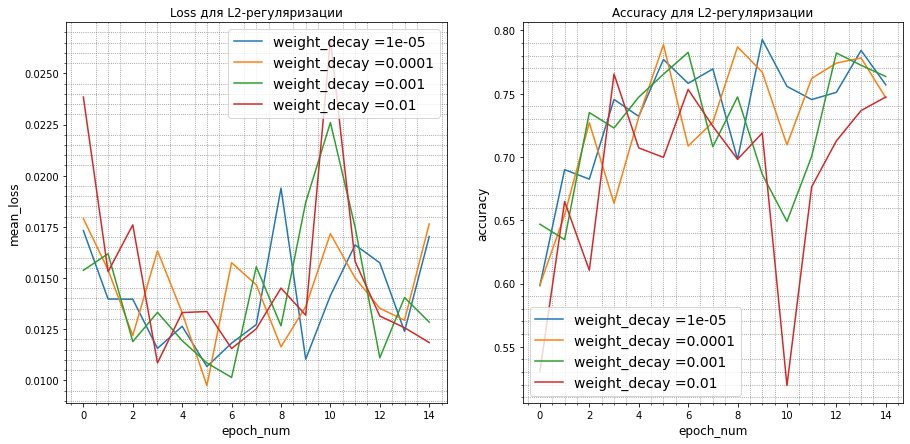

In [169]:
#!g1.1
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for w in weights:
    plt.plot(np.arange(15), l2_res[w][0], label='weight_decay ='+str(w))
plt.legend(fontsize = 14)
plt.title("Loss для L2-регуляризации")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
for w in weights:
    plt.plot(np.arange(15), l2_res[w][1], label='weight_decay ='+str(w))
plt.legend(fontsize = 14)
plt.title("Accuracy для L2-регуляризации")

plt.show()

L2-регуляризация с weight_decay=1e-05 выглядит наиболее устойчивой (насколько вообще можно судить по этим графикам), поэтому для финальной версии выберем ее.

## Лучшее качество

Итак, для финальной версии ResNet18 берем аугментированную выборку, batch_size=16, LR=0.0001, weights_decay=1e-05 (L2-регуляризация). Посмотрим, что из этого вышло.

In [188]:
#!g1.1
aug_trasform = transforms.Compose([
    RandomHorizontalFlip(), RandomCrop(), ColorBrightness(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

aug_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_dev_sets = torch.utils.data.ConcatDataset([trainset, aug_trainset])

train_data_loader = DataLoader(train_dev_sets, batch_size=16,
                         shuffle=True, num_workers=2)
test_data_loader = DataLoader(testset, batch_size=16,
                        shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
#!g1.1
resnet_model = ResNet18(num_classes=10)
model = Net(resnet_model)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-05)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
fin_loss, fin_acc = train(model)

Epoch : 0 mean_loss : 0.05530321033000946 acc : 0.6973
Epoch : 1 mean_loss : 0.03896371688768268 acc : 0.7836
Epoch : 2 mean_loss : 0.0351304267808795 acc : 0.8128
Epoch : 3 mean_loss : 0.037931358342058956 acc : 0.8189
Epoch : 4 mean_loss : 0.047576764100044966 acc : 0.7917
Epoch : 5 mean_loss : 0.03622595859616995 acc : 0.8332


Оно скоро досчитается... Но пока и так выглядит хорошо!

К сожалению, в самый неподходящий момент вычисления прекратились и все пришлось запускать заново. Результаты получились хорошие.

In [20]:
#!g1.1
resnet_model = ResNet18(num_classes=10)
model = Net(resnet_model)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-05)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
fin_loss, fin_acc = train(model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 0 mean_loss : 0.0422730176076293 acc : 0.7653
Epoch : 1 mean_loss : 0.03449769308269024 acc : 0.8151
Epoch : 2 mean_loss : 0.03596759356223047 acc : 0.8072
Epoch : 3 mean_loss : 0.03282538735438138 acc : 0.8339
Epoch : 4 mean_loss : 0.03834766796687618 acc : 0.8243
Epoch : 5 mean_loss : 0.03981805636286736 acc : 0.8213
Epoch : 6 mean_loss : 0.04580768802647944 acc : 0.813
Epoch : 7 mean_loss : 0.041139201542828234 acc : 0.8281
Epoch : 8 mean_loss : 0.04441263578713406 acc : 0.8297
Epoch : 9 mean_loss : 0.042419262576987964 acc : 0.8394
Epoch : 10 mean_loss : 0.04399445051066577 acc : 0.8298
Epoch : 11 mean_loss : 0.04432098207352683 acc : 0.8349
Epoch : 12 mean_loss : 0.04669334679426392 acc : 0.8338
Epoch : 13 mean_loss : 0.04959696417218074 acc : 0.825
Epoch : 14 mean_loss : 0.044637989480729445 acc : 0.8415


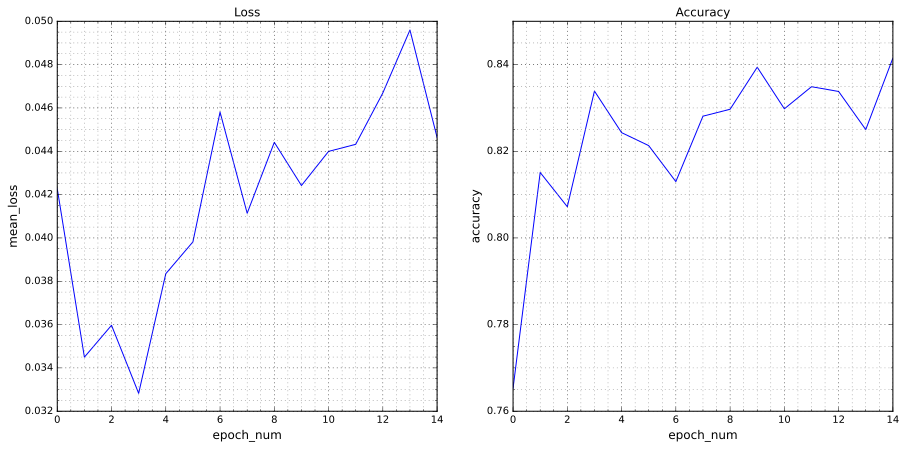

In [21]:
#!g1.1
fig = plt.figure(figsize=(15,7))
#plt.title('Кросс-энтропия')

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), fin_loss)
#plt.legend(fontsize = 14)
plt.title("Loss")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), fin_acc)
#plt.legend(fontsize = 14)
plt.title("Accuracy")

plt.show()

Таким образом, правильно подобрав параметры, удалось существенно улучшить качество. Качество классификации финальной нейросети составляет 0.84, в то время как баз